#### Installing packages

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
def create_train_test_split(X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42069)
    return X_train, X_test, Y_train, Y_test

plot-confusion-matrix function from class

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

#### Load preprocessed Data Frame

In [3]:
df = pd.read_csv('mbti_preprocessed_complete.csv')
display(df.head())

,Unnamed: 0,type,posts,encodedType,preprocessed_posts,extro_intro,intu_obs,feel_think,prosp_judg
0,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,8,"['youtube', 'tumblr', 'enfp', 'intj', 'moment'...",0,1,1,0
1,1,ENTP,'I'm finding the lack of me in these posts ver...,3,"['im', 'finding', 'the', 'lack', 'of', 'post',...",1,1,0,1
2,2,INTP,'Good one _____ https://www.youtube.com/wat...,11,"['good', 'one', 'youtube', 'of', 'course', 'i'...",0,1,0,1
3,3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",10,"['dear', 'intp', 'i', 'enjoyed', 'conversation...",0,1,0,0
4,4,ENTJ,'You're fired.|||That's another silly misconce...,2,"['youre', 'fired', 'thats', 'another', 'silly'...",1,1,0,0


Select columns which will serve as target and training data. Here target is the 16 MBTI categories. While the training data consists of the preprocessed posts which will be verctorized using TF-IDF.

In [4]:
Y = df.iloc[:,3].values
X = df.iloc[:,4].values

tf_idf_vectorizer = TfidfVectorizer(use_idf=True, min_df = 0.1, max_df = 0.3)

X = pd.DataFrame(tf_idf_vectorizer.fit_transform(X).toarray(), columns=tf_idf_vectorizer.get_feature_names_out())

Split into train and test datasets.

In [5]:
X_train, X_test, Y_train, Y_test = create_train_test_split(X, Y)

### Models: Centroides vs KNN
Load packages

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV
from imblearn.pipeline import Pipeline

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier

In [7]:
pipeline = Pipeline([ ('estimator', None) ]) 

#### Centroids

In [8]:
pipeline.set_params(estimator=NearestCentroid())

Pipeline(steps=[('estimator', NearestCentroid())])

##### Model

Classification Report:
              precision    recall  f1-score   support

        INFJ       0.36      0.56      0.44        55
        ENTP       0.40      0.43      0.42       212
        INTP       0.46      0.57      0.51        74
        INTJ       0.56      0.61      0.58       196
        ENTJ       0.16      0.55      0.25        11
        ENFJ       0.09      0.21      0.13        14
        INFP       0.29      0.64      0.40        11
        ENFP       0.29      0.57      0.39        28
        ISFP       0.66      0.42      0.51       436
        ISTP       0.54      0.56      0.55       545
        ISFJ       0.64      0.48      0.55       365
        ISTJ       0.55      0.56      0.56       378
        ESTP       0.51      0.67      0.58        58
        ESFP       0.40      0.47      0.43        73
        ESTJ       0.41      0.51      0.45        61
        ESFJ       0.53      0.65      0.58        86

    accuracy                           0.52      2603
   

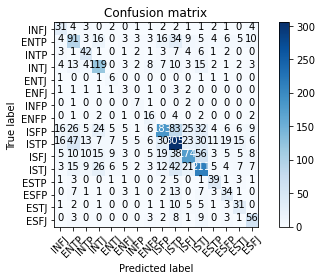

In [11]:
pipeline.fit(X_train, Y_train)
prediction = pipeline.predict(X_test)

print("Classification Report:")
print(classification_report(Y_test, prediction, target_names=df['type'].unique()))

accuracy_ncc16 = cross_val_score(pipeline, X_train, Y_train, cv=3, scoring='accuracy')
print(f"Average Accuracy = {accuracy_ncc16.mean() * 100.0}%")

cnf = confusion_matrix(Y_test, prediction)
np.set_printoptions(precision = 2)
plot_confusion_matrix(cnf, classes = df['type'].unique())

#### KNN

In [8]:
pipeline.set_params(estimator=KNeighborsClassifier())

Pipeline(steps=[('estimator', KNeighborsClassifier())])

##### Grid Search
Determening best k for the Model.

In [9]:
parameters = {
    'n_neighbors':range(1,200,2),
}

gs = GridSearchCV(KNeighborsClassifier(),
                  parameters,
                  scoring='accuracy',
                  cv=cv,
                  return_train_score=False)

gs.fit(X_train, Y_train)
results = pd.DataFrame(gs.cv_results_)
#display(results)
print(f"best score is {gs.best_score_} with params {gs.best_params_}")

best score is 0.4919301712779973 with params {'n_neighbors': 111}


##### Model

Classification Report k=111:
              precision    recall  f1-score   support

        INFJ       0.55      0.33      0.41        55
        ENTP       0.50      0.28      0.36       212
        INTP       0.66      0.42      0.51        74
        INTJ       0.53      0.62      0.57       196
        ENTJ       0.00      0.00      0.00        11
        ENFJ       0.00      0.00      0.00        14
        INFP       0.00      0.00      0.00        11
        ENFP       0.77      0.36      0.49        28
        ISFP       0.46      0.45      0.46       436
        ISTP       0.39      0.79      0.53       545
        ISFJ       0.66      0.33      0.44       365
        ISTJ       0.58      0.45      0.51       378
        ESTP       0.63      0.38      0.47        58
        ESFP       0.55      0.30      0.39        73
        ESTJ       0.61      0.28      0.38        61
        ESFJ       0.60      0.42      0.49        86

    accuracy                           0.48      26

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


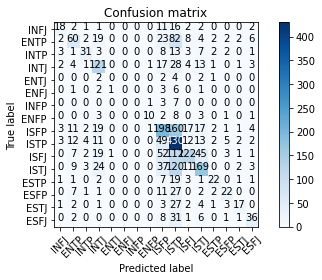

In [12]:
for k in gs.best_params_.values():
    pipeline.set_params(estimator__n_neighbors=k)
    pipeline.fit(X_train, Y_train)
    prediction = pipeline.predict(X_test)
    
    print(f"Classification Report k={k}:")
    print(classification_report(Y_test, prediction, target_names=df['type'].unique()))
    
    cnf = confusion_matrix(Y_test, prediction)
    np.set_printoptions(precision = 2)
    plot_confusion_matrix(cnf, classes = df['type'].unique()) 